# Software Development Capability Analysis
## by Marc Vitalis

## Investigation Overview

In this investigation we want to analyze the software development capability of our team. Capability is the amount of work that the team can deliver. The main focus is learning and improving the cycle time of each work item by dissecting the timestamps of the stages in the development, `new`, `doing` and `done`. Aside from that, we'll look at the `estimates` and how efficient it is in forecasting work.

## Dataset Overview

The dataset contains 5-year worth of workitems done at around ~1500 workitems. The team underwent 3 eras of software development methodologies: waterfall (Oct 2014 - May 2017), hybrid (June 2017 - July 2018), scrums (July 2018 - present). The attributes included are the timestamps of the 3 stages (`new`, `doing`, `done`), along with other descriptive information such as workitem type, the estimate, the resource assigned to and others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas.api.types import CategoricalDtype
import pandas.plotting._converter as pandacnv
from scipy.interpolate import spline

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
pandacnv.register()

In [2]:
# load in the dataset into a pandas dataframe
workitems = pd.read_csv('workitems_master.csv')

In [3]:
# convert to dates
workitems.new = pd.to_datetime(workitems.new)
workitems.doing = pd.to_datetime(workitems.doing)
workitems.done = pd.to_datetime(workitems.done)

In [4]:
# change sprint to int
workitems.loc[workitems.sprint.isna(), 'sprint'] = 0
workitems.sprint = workitems.sprint.astype(int)

In [5]:
workitem_types = CategoricalDtype(categories = ['Story', 'Bug', 'Issue'], ordered=True)
workitems.workitem_type = workitems.workitem_type.astype(workitem_types)

In [6]:
#zero sum should be converted to a day of work if they have worked on it at least 2h
zero_work = workitems.actual_work == 0
workitems.loc[zero_work, 'actual_work'] = 1

#just remove the zero effort ones
workitems = workitems[((workitems.done - workitems.doing) / pd.Timedelta(hours = 1)) >  2]
#remove the time stamps in new, doing and done
workitems.new = pd.to_datetime(workitems.new.dt.date)
workitems.doing = pd.to_datetime(workitems.doing.dt.date)
workitems.done = pd.to_datetime(workitems.done.dt.date)

In [7]:
# let's extract the dates first
workitems['doing_year'] = workitems.doing.dt.year
workitems['done_year'] = workitems.done.dt.year
workitems['new_year'] = workitems.new.dt.year

workitems['doing_month'] = workitems.doing.dt.strftime('%b')
workitems['done_month'] = workitems.done.dt.strftime('%b')
workitems['new_month'] = workitems.new.dt.strftime('%b')

workitems['doing_dow'] = workitems.doing.dt.strftime('%a')
workitems['done_dow'] = workitems.done.dt.strftime('%a')
workitems['new_dow'] = workitems.new.dt.strftime('%a')

workitems['doing_my'] = workitems.doing.dt.strftime('%b %Y')
workitems['done_my'] = workitems.done.dt.strftime('%b %Y')
workitems['new_my'] = workitems.new.dt.strftime('%b %Y')

weekdays_type = CategoricalDtype(categories=['Mon' , 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
months_type = CategoricalDtype(categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)
my_type = CategoricalDtype(categories = pd.to_datetime(np.arange(workitems.new.min(), workitems.done.max() + pd.DateOffset(months = 1), 1, dtype='datetime64[M]')).strftime('%b %Y'), ordered = True)

workitems.doing_month = workitems.doing_month.astype(months_type)
workitems.done_month = workitems.done_month.astype(months_type)
workitems.new_month = workitems.new_month.astype(months_type)

workitems.doing_dow = workitems.doing_dow.astype(weekdays_type)
workitems.done_dow = workitems.done_dow.astype(weekdays_type)
workitems.new_dow = workitems.new_dow.astype(weekdays_type)

workitems.new_my = workitems.new_my.astype(my_type)
workitems.doing_my = workitems.doing_my.astype(my_type)
workitems.done_my = workitems.done_my.astype(my_type)

workitems['wi_weight'] = 0
workitems.loc[workitems.workitem_type == 'Story', 'wi_weight'] = 2
workitems.loc[workitems.workitem_type == 'Bug', 'wi_weight'] = 1

## Distribution of Actual Work

The unit of choice when calculating the actual work is by `Days`. The actual work is computed from the first time it's in doing stage and the first time it's in the done stage. To weed out workitems with no effort, there should be 2h interval between doing and done stage, then we treat that as one day worth of work effort.

The actual work is in `logarithmic` view to properly look at values at the upper range with max of 94 days.

Aside from huge number of workitems that can be done in a day, we can see a somehow steady distribution from 2 to 20 days.

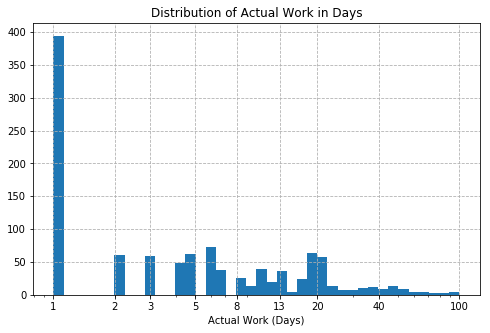

In [8]:
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(workitems['actual_work'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'actual_work', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 3, 5, 8, 13, 20, 40, 100], [1, 2, 3, 5, 8, 13, 20, 40, 100])
plt.xlabel('Actual Work (Days)')
plt.title('Distribution of Actual Work in Days')
plt.grid(linestyle='--')

plt.show()

## Distribution of Estimates

Estimates are just points to describe the workitem size. It should imply that the bigger in size, it should take longer to do development. Most of the time we are using the poker estimation sequence `[1, 2, 3, 5, 8, 13, 20, 40, 100]`, which is somehow close to the fibonacci sequence. Estimates peaked at 8 points then gradually decrease in frequency in less or more than that.

This graph also shows that we have varying story sizes, which may be more complex to analyze.

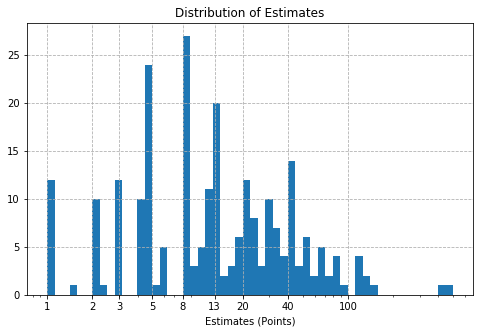

In [9]:
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(workitems['estimate'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'estimate', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 3, 5, 8, 13, 20, 40, 100], [1, 2, 3, 5, 8, 13, 20, 40, 100])
plt.xlabel('Estimates (Points)')
plt.title('Distribution of Estimates')
plt.grid(linestyle='--')
plt.show()

## Actual Work vs Estimates

At correlation value of 0.34, it's not enough to conclude that estimates is a good way to forecast amount of work the team can do on a certain period of time. However, our investigation shows that most of the data are within 1 - 20 days of work and 1 - 40 points of estimates.

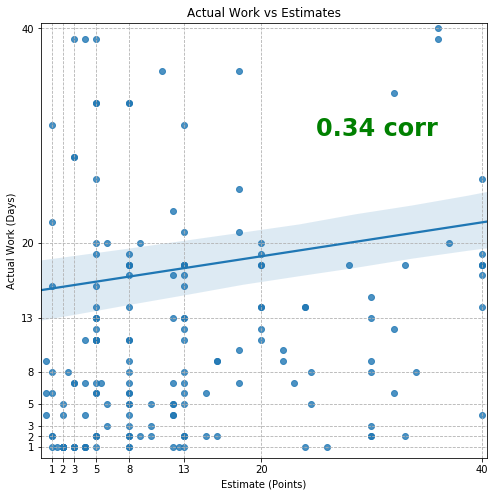

In [10]:
plt.figure(figsize=(8, 8))
g = sb.regplot(data = workitems, x = 'estimate', y = 'actual_work')
ticks = [1, 2, 3, 5, 8, 13, 20, 40, 100]
plt.xticks(ticks)
plt.yticks(ticks);
plt.ylim([0, 40.5])
plt.xlim([0, 40.5])
plt.title('Actual Work vs Estimates')
plt.grid(linestyle='--')
plt.xlabel('Estimate (Points)')
plt.ylabel('Actual Work (Days)')
g.text(25, 30, f'{workitems.actual_work.corr(workitems.estimate):.2f} corr', fontsize=24, fontweight='bold', color = 'Green');

## Work Distribution

We would like to see how the work is distributed per month. We can observe during waterfall era, it's hard to observe any pattern and there are tons of outliers in it. The hybrid era started May 2017, however, it underwent some ramp up time that we are starting to see its benefits 5 months later.

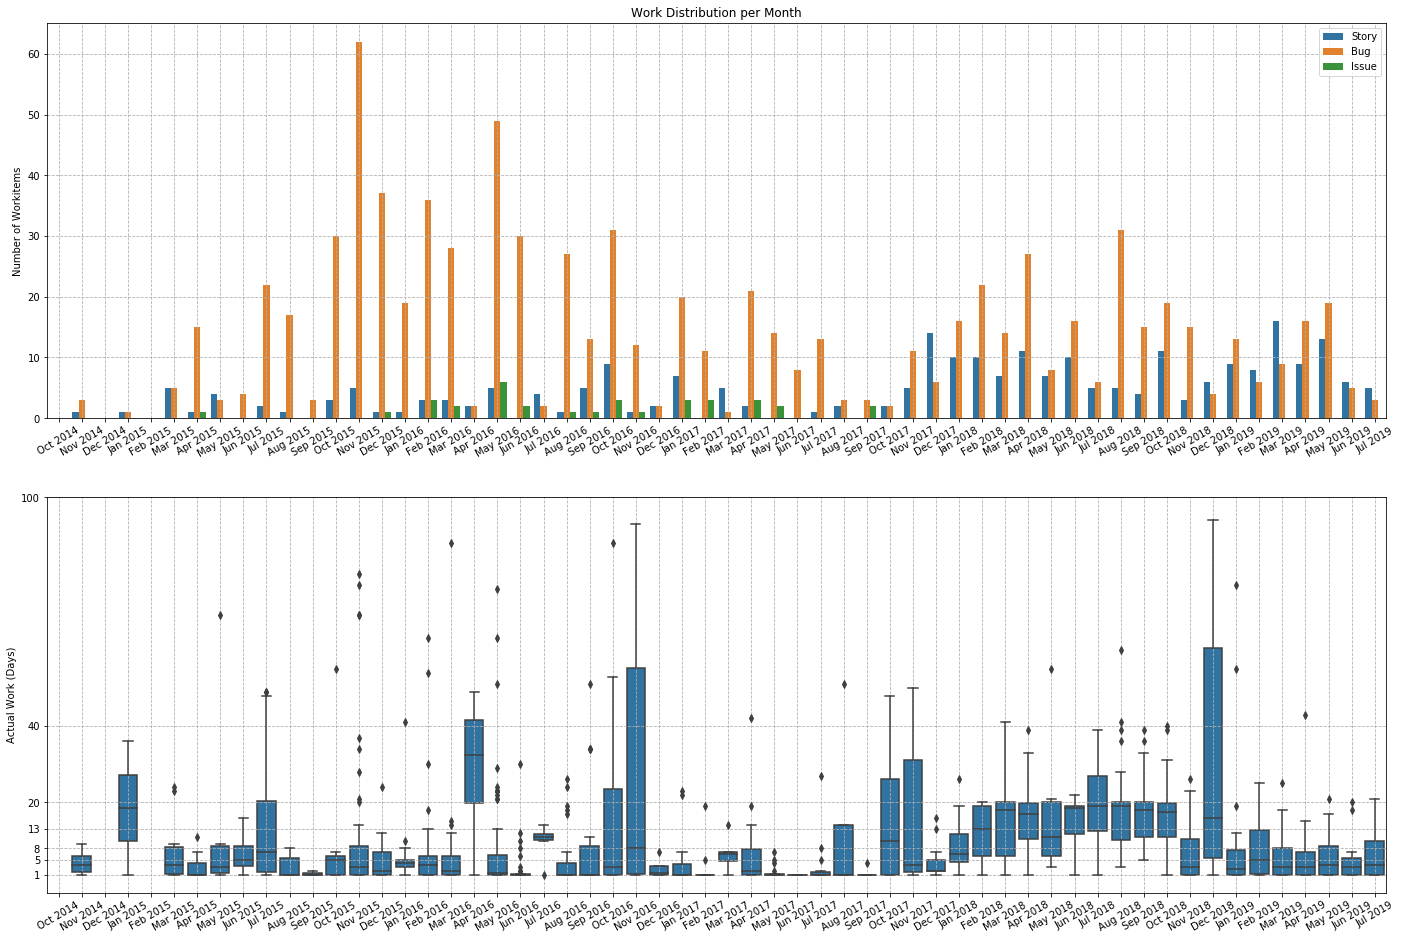

In [11]:
base_color = sb.color_palette()[0]

plt.figure(figsize = (24, 16))
plt.subplot(2, 1, 1)
g = sb.countplot(data = workitems, x = 'done_my', hue = 'workitem_type');
plt.legend(loc = 'upper right')
g.set_xticklabels(g.get_xticklabels(), rotation = 30);
plt.title('Work Distribution per Month')
plt.grid(linestyle='--')
plt.ylabel('Number of Workitems')
plt.xlabel('')

plt.subplot(2, 1, 2)
g = sb.boxplot(data = workitems, x = 'done_my', y = 'actual_work', color = base_color)
plt.yticks([1, 5, 8, 13, 20, 40, 100]);
plt.ylabel('Actual Work (Days)')
plt.grid(linestyle='--')
plt.xlabel('')
g.set_xticklabels(g.get_xticklabels(), rotation = 30);

## Capability of the Main Developers
As we can compare, waterfall era has huge gaps in developer's capability. This is a bit inconclusive as there's developers are working on workitems with no restrictions. In the latter era, we can see a better visual with developers' capability has closer gap.

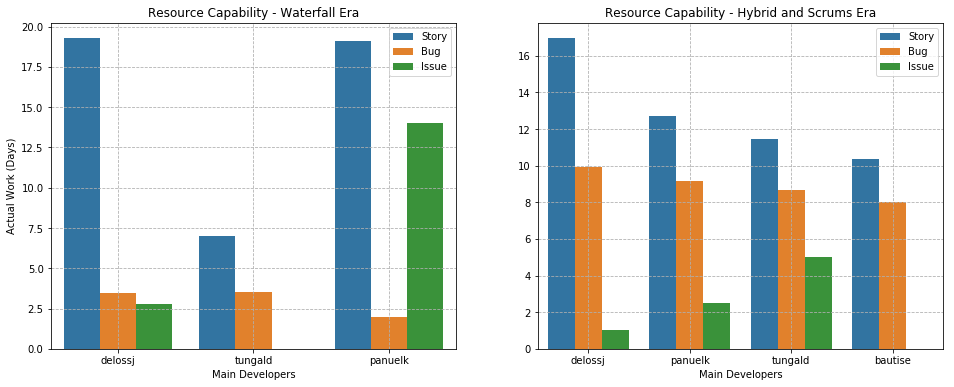

In [12]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)

main_devs_old = workitems[(workitems.assigned_to.isin(['panuelk', 'delossj', 'tungald', 'bautise'])) & (workitems.era == 'waterfall')]
sb.barplot(data = main_devs_old, x = 'assigned_to', y = 'actual_work', hue = 'workitem_type', ci = None)
plt.legend(loc = 'upper right')
plt.title('Resource Capability - Waterfall Era')
plt.ylabel('Actual Work (Days)')
plt.xlabel('Main Developers')
plt.grid(linestyle='--')

plt.subplot(1, 2, 2)

main_devs_new = workitems[(workitems.assigned_to.isin(['panuelk', 'delossj', 'tungald', 'bautise'])) & (workitems.era != 'waterfall')]
sb.barplot(data = main_devs_new, x = 'assigned_to', y = 'actual_work', hue = 'workitem_type', ci = None)
plt.legend(loc = 'upper right')
plt.title('Resource Capability - Hybrid and Scrums Era')
plt.ylabel('')
plt.xlabel('Main Developers')
plt.grid(linestyle='--')

## Developers Capability Per Month

As we can observe here, after a major spike in productivity, the developers are starting their capability on the latter part of software development. Lower value in capability the better.

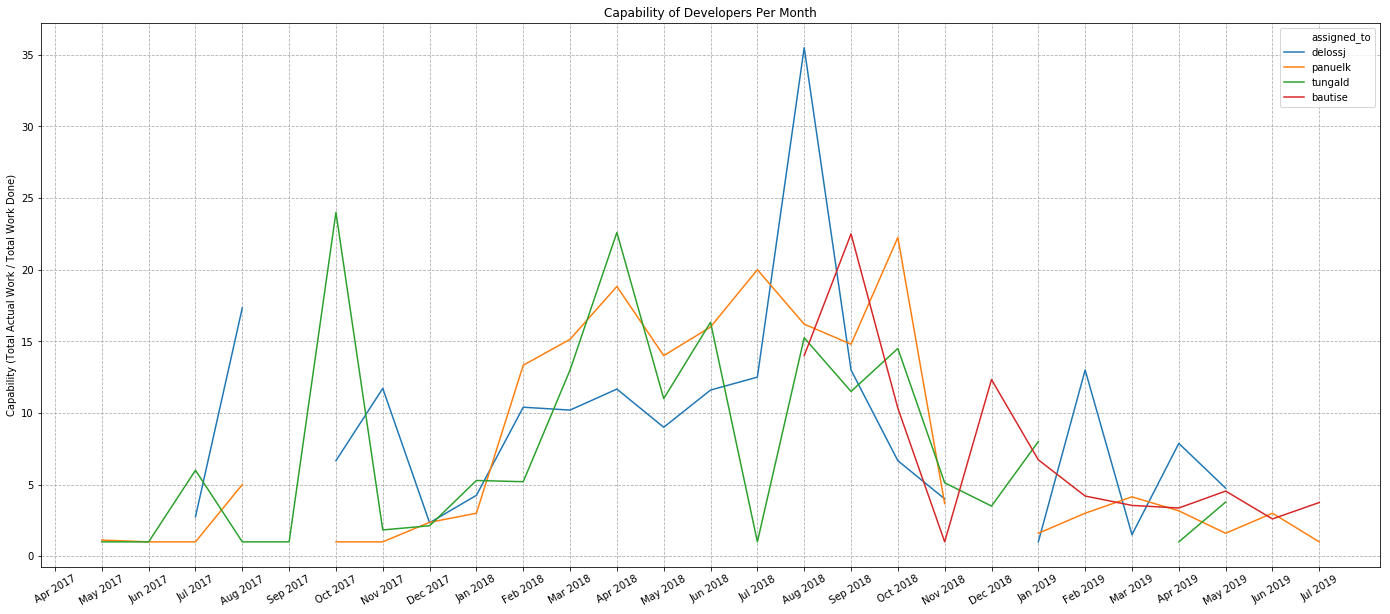

In [13]:
dev_cap = workitems[ \
    (workitems.assigned_to.isin(['panuelk', 'delossj', 'tungald', 'bautise'])) & \
    (workitems.era != 'waterfall') & (workitems.workitem_type != 'Issue') \
].groupby(['done_my', 'assigned_to']).agg({'actual_work': 'sum', 'wi_weight' : 'sum'}).reset_index()

dev_cap['capability'] = dev_cap.actual_work / dev_cap.wi_weight

plt.figure(figsize = (24, 10))
g = sb.lineplot(data = dev_cap, x = 'done_my', y = 'capability', hue = 'assigned_to')
plt.draw()
g.set_xticklabels(g.get_xticklabels(), rotation = 30);
plt.title('Capability of Developers Per Month')
plt.ylabel('Capability (Total Actual Work / Total Work Done)')
plt.xlabel('');
plt.grid(linestyle='--')

## Team Capability Per Month

After adjustments and humps, workitems starts to normalize in the latter part, flatlining on the last 4 months.

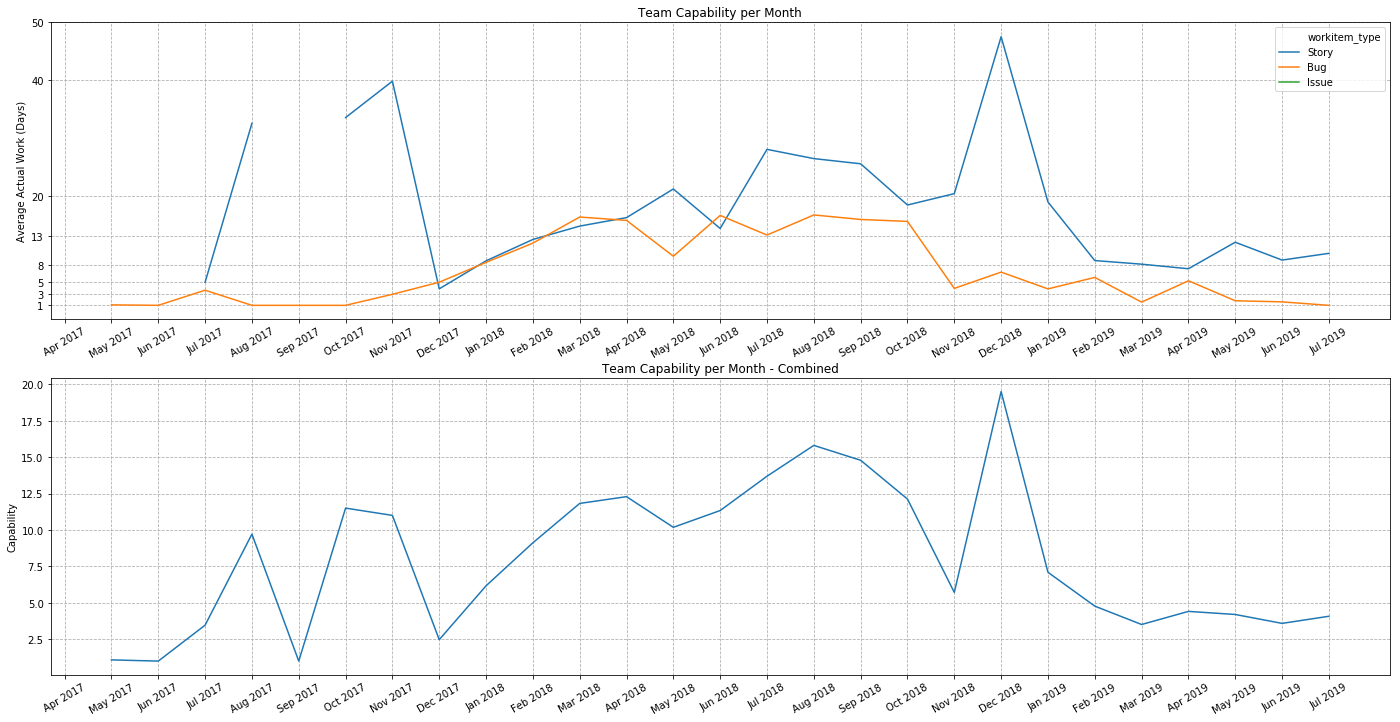

In [14]:
work_actual_mean = workitems[workitems.era != 'waterfall'].groupby(['done_year', 'done_month', 'done_my', 'workitem_type']).actual_work.mean().reset_index()

plt.figure(figsize = (24, 12))
plt.subplot(2, 1, 1)
g = sb.lineplot(data = work_actual_mean, x = 'done_my', y = 'actual_work', hue = 'workitem_type')
plt.yticks([1, 3, 5, 8, 13, 20, 40, 50]);
plt.title('Team Capability per Month')
plt.xlabel('')
plt.ylabel('Average Actual Work (Days)')
plt.draw()
g.set_xticklabels(g.get_xticklabels(), rotation = 30)
plt.grid(linestyle='--')

plt.subplot(2, 1, 2)
team_cap = workitems[(workitems.era != 'waterfall') & (workitems.workitem_type != 'Issue')].groupby('done_my').agg({'actual_work': 'sum', 'wi_weight' : 'sum'}).reset_index()
team_cap.loc[team_cap.wi_weight != 0, 'capability'] = team_cap.actual_work / team_cap.wi_weight
g = sb.lineplot(data = team_cap, x = 'done_my', y = 'capability')
plt.draw()
g.set_xticklabels(g.get_xticklabels(), rotation = 30)
plt.title('Team Capability per Month - Combined')
plt.xlabel('')
plt.ylabel('Capability')
plt.grid(linestyle='--')